In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D # Estamos utilizando agora os layers de 1 dimensão
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [2]:
!wget https://lazyprogrammer.me/course_files/spam.csv

'wget' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [4]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1) # Removendo colunas desnecessárias

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.columns = ['labels', 'data'] # Renomeando colunas

In [9]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1}) # Criando coluna de labels binários
Y = df['b_labels'].values

In [12]:
# Dividindo os dados em treino e teste
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [13]:
# Convertendo sentenças em sequências
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [14]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Número de palavras no vocabulário:', V)

Número de palavras no vocabulário: 7207


In [16]:
data_train = pad_sequences(sequences_train) # Padding para manter o tamanho correto para a entrada da rede
print('Formato dos dados de treino:', data_train.shape)

T = data_train.shape[1] # Tamanho da sequência

Formato dos dados de treino: (3733, 121)


In [17]:
data_test = pad_sequences(sequences_test, 
                          maxlen=T # Tamanho da sequência
                          ) # Padding para manter o tamanho N x T
print('Formato dos dados de teste:', data_test.shape)

Formato dos dados de teste: (1839, 121)


In [18]:
# Criando o modelo
D = 20 # Dimensão do embedding
# O embedding é uma matriz de V x D, onde V é o número de palavras no vocabulário e D é a dimensão do embedding

i = Input(shape=(T,)) # Input layer
x = Embedding(V + 1, D)(i) # Output layer
x = Conv1D(32, 3, activation='relu')(x) # Camada de convolução de uma dimensão
x = MaxPooling1D(3)(x) # Camada de pooling para reduzir a dimensionalidade
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x) # Camada de pooling global
x = Dense(1, activation='sigmoid')(x) # Camada densa de saída, que verificará se é spam ou não (0 ou 1)

model = Model(i, x)

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 121)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 121, 20)        │       144,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 119, 32)        │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 39, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 37, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,153 (692.00 KB)

 Trainable params: 177,153 (692.00 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print('Treinando o modelo...')
r = model.fit(data_train, 
              Ytrain, 
              epochs=5, 
              validation_data=(data_test, Ytest))

Treinando o modelo...
Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8635 - loss: 0.4604 - val_accuracy: 0.8711 - val_loss: 0.2484
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9420 - loss: 0.1661 - val_accuracy: 0.9701 - val_loss: 0.0948
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9902 - loss: 0.0421 - val_accuracy: 0.9826 - val_loss: 0.0724
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9926 - loss: 0.0261 - val_accuracy: 0.9848 - val_loss: 0.0657
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9972 - loss: 0.0105 - val_accuracy: 0.9810 - val_loss: 0.0940


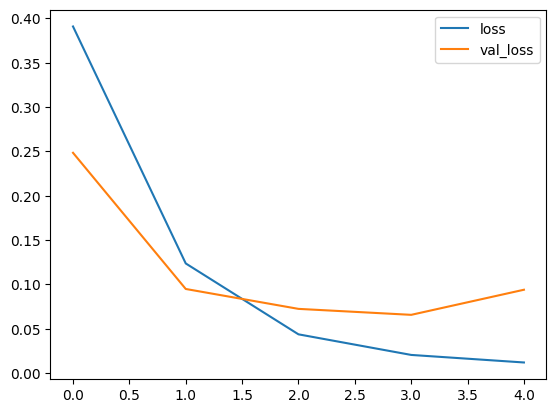

In [21]:
# Plotando os resultados de erro no treino e validação
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

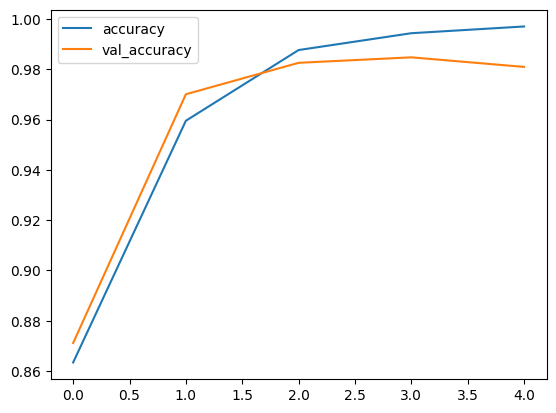

In [22]:
# Plotando os resultados de acurácia no treino e validação
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Matriz de confusão sem normalização
[[1602    0]
 [ 237    0]]


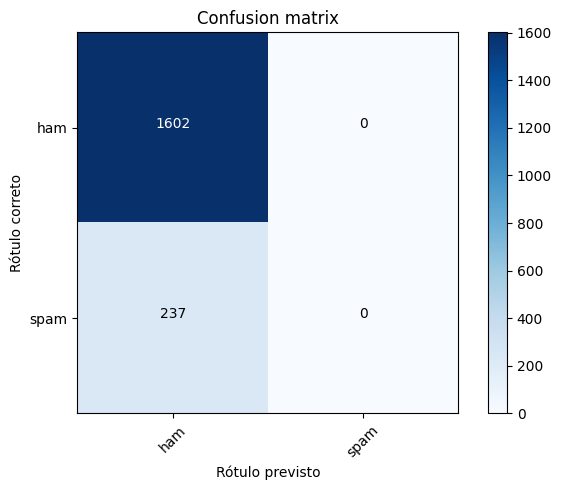

In [24]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Rótulo correto')
    plt.xlabel('Rótulo previsto')
    plt.show()

p_test = model.predict(data_test).argmax(axis=1)
cm = confusion_matrix(Ytest, p_test)
plot_confusion_matrix(cm, ['ham', 'spam'])

In [25]:
labels = ['ham', 'spam']

In [30]:
# Verificando as mensagens classificadas incorretamente
misclassified_idx = np.where(p_test != Ytest)[0]
i = np.random.choice(misclassified_idx)
print(df_test.iloc[i])
print('Rótulo verdadeiro:', labels[Ytest[i]])
print('Rótulo previsto:', labels[p_test[i]])

This weeks SavaMob member offers are now accessible. Just call 08709501522 for details! SavaMob, POBOX 139, LA3 2WU. Only å£1.50/week. SavaMob - offers mobile!
Rótulo verdadeiro: spam
Rótulo previsto: ham
